# Importing libraries

In [1]:

import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Configuring the TPU

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = STRATEGY.num_replicas_in_sync
print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

Running on CPU or GPU
N_REPLICAS: 1, IS_TPU: False


 # Loading dataset

In [3]:
path='/kaggle/input/rsna-breast-cancer-detection/'
train_data=pd.read_csv(path+'train.csv')
test_data=pd.read_csv(path+'test.csv')
path_train_images = "/kaggle/input/rsna_mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512"

In [4]:
# Load the csv file into a pandas dataframe
df = pd.read_csv(path+'train.csv')
print('Imbalanced dataset')
print('Number of images without cancer: ', len(df[df['cancer'] == 0]))
print('Number of images with cancer: ', len(df[df['cancer'] == 1]))
print(f'Total images: {len(df)}')

#reduce the number of samples with df['cancer'] == 0 from 53548 to some lesser number
df = df[df['cancer'] == 0].sample(4632, random_state=42).append(df[df['cancer'] == 1])
print('\nBalanced dataset')
print('Number of images without cancer: ', len(df[df['cancer'] == 0]))
print('Number of images with cancer: ', len(df[df['cancer'] == 1]))
print(f'Total images: {len(df)}')

# strip all other columns that are not needed
df = df[['patient_id', 'image_id', 'cancer']]

# Convert the data type of the columns to string
df['image_id'] = df['image_id'].astype(str)
df['cancer'] = df['cancer'].astype(str)
df['patient_id'] = df['patient_id'].astype(str)
df["path"] = df["patient_id"].map(str) + "/" + df["image_id"] + '.png'
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Imbalanced dataset
Number of images without cancer:  53548
Number of images with cancer:  1158
Total images: 54706

Balanced dataset
Number of images without cancer:  4632
Number of images with cancer:  1158
Total images: 5790


In [5]:
val_df

,patient_id,image_id,cancer,path
30618,42729,919945511,0,42729/919945511.png
45641,59121,702664455,0,59121/702664455.png
5172,15573,397277886,0,15573/397277886.png
15857,2685,866280834,0,2685/866280834.png
5976,16488,1920435875,0,16488/1920435875.png
...,...,...,...,...
42538,55842,115057946,1,55842/115057946.png
50539,64534,1551728826,1,64534/1551728826.png
54675,9954,403809542,0,9954/403809542.png
8155,18709,1843448086,0,18709/1843448086.png


In [6]:
# Create ImageDataGenerators for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Generate batches of data from the dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_train_images,
    x_col='path',
    y_col='cancer',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(512, 512, 3))
    
valid_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=path_train_images,
    x_col='path',
    y_col='cancer',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(512, 512, 3))

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4632 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1158 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Unique values: 233
Max: 235
Min: 0


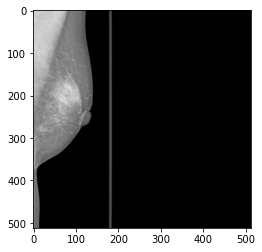

In [8]:
sample = cv2.imread('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/10006/1459541791.png')
sample.shape
plt.imshow(sample)
print(f'Unique values: {len(np.unique(sample))}')
print(f'Max: {sample.max()}')
print(f'Min: {sample.min()}')